In [2]:
%pip install --upgrade scikit-learn==1.8.0

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 2.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/8.0 MB 3.0 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.0 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.0 MB 2.2 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.0 MB 1.9 MB/s eta 0:00:04
   ----------- ---------------------------- 2.4/8.0 MB 1.7 MB/s eta 0:00:04
   ----------- ---------------------------- 2.4/8.0 MB 1.7 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/8.0 MB 1.5 MB/s eta 0:00:04
   -------------- ------------------------- 2.9/8.0 MB 1.4 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/8.0 MB 1.4 MB/s eta 0:00:04
   ---------------- -------

In [3]:
import sklearn
print(sklearn.__version__)


1.8.0


In [4]:
import numpy as np
import pandas as pd 

In [5]:
#loading the datasets

fear_greed = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

fear_greed.head(4)



,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04


In [6]:
trades.head(3)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [7]:
trades.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [8]:
fear_greed.shape
trades.shape

fear_greed.isna().sum()
trades.isna().sum()

trades.duplicated().sum()


0

In [9]:
fear_greed['date'] = pd.to_datetime(fear_greed['date'])


In [10]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')


In [11]:
trades['date'] = trades['Timestamp'].dt.date
fear_greed['date'] = fear_greed['date'].dt.date


In [12]:
# Convert timestamps
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

# Extract date
trades['date'] = trades['Timestamp'].dt.date
fear_greed['date'] = fear_greed['date'].dt.date


In [13]:
trades[['Timestamp', 'date']].head()
fear_greed[['date', 'classification']].head()


,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [14]:
merged = trades.merge(
    fear_greed[['date', 'classification']],
    on='date',
    how='left'
)


In [15]:
daily_trader = merged.groupby(
    ['Account', 'date', 'classification']
).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_per_day=('Closed PnL', 'count'),
    avg_trade_size=('Size Tokens', 'mean'),
    long_trades=('Side', lambda x: (x == 'buy').sum()),
    short_trades=('Side', lambda x: (x == 'sell').sum())
).reset_index()


In [16]:
daily_trader['long_short_ratio'] = (
    daily_trader['long_trades'] /
    (daily_trader['short_trades'] + 1)
)

daily_trader['win_day'] = (daily_trader['daily_pnl'] > 0).astype(int)


In [17]:
daily_trader.groupby('classification')['daily_pnl'].mean()


classification
Extreme Greed     35393.098355
Fear             209372.662205
Greed             99675.516731
Neutral           19842.797260
Name: daily_pnl, dtype: float64

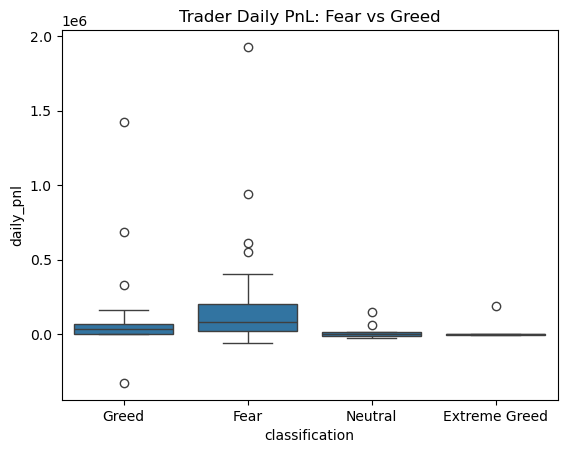

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=daily_trader,
    x='classification',
    y='daily_pnl'
)
plt.title("Trader Daily PnL: Fear vs Greed")
plt.show()


In [19]:
daily_trader.groupby('classification')[[
    'trades_per_day',
    'long_short_ratio',
    'avg_trade_size'
]].mean()


,trades_per_day,long_short_ratio,avg_trade_size
classification,,,
Extreme Greed,1392.40000,0.0,23947.107572
Fear,4183.46875,0.0,3875.222985
Greed,1134.03125,0.0,3283.056237
Neutral,892.62500,0.0,2254.876974


In [20]:
daily_trader['freq_segment'] = pd.qcut(
    daily_trader['trades_per_day'],
    q=3,
    labels=['Low', 'Medium', 'High']
)


In [21]:
daily_trader.groupby(
    ['freq_segment', 'classification']
)['daily_pnl'].mean()


C:\Users\hp\AppData\Local\Temp\ipykernel_2164\1276185209.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_trader.groupby(


freq_segment  classification
Low           Extreme Greed      -2782.008070
              Fear               64372.536756
              Greed              47200.875882
              Neutral            26254.572028
Medium        Extreme Greed      -7919.471032
              Fear               69926.506353
              Greed             119772.681893
              Neutral            18297.337631
High          Extreme Greed      95224.489473
              Fear              305952.446651
              Greed             231139.633135
              Neutral            -9125.157325
Name: daily_pnl, dtype: float64

In [22]:
daily_trader['profit_label'] = (daily_trader['daily_pnl'] > 0).astype(int)


In [23]:
X = daily_trader[
    ['trades_per_day', 'avg_trade_size', 'long_short_ratio']
]

# Encode sentiment
X = pd.get_dummies(
    daily_trader[['classification']].join(X),
    drop_first=True
)

y = daily_trader['profit_label']


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # IMPORTANT
)


In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [26]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred))


Accuracy: 87.50%
Balanced Accuracy: 79.49%
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.92      0.92      0.92        13

    accuracy                           0.88        16
   macro avg       0.79      0.79      0.79        16
weighted avg       0.88      0.88      0.88        16



In [29]:
import pickle

with open('Trader_sentiment_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    print("Picke file created successfully")

Picke file created successfully
